In [1]:
# Similar to the other notebook but the data is sourced directly from the ExpDev API.  See ../expdev07/README.md
import os
import pandas as pd
import json

dict_keys(['confirmed', 'deaths', 'latest', 'recovered'])


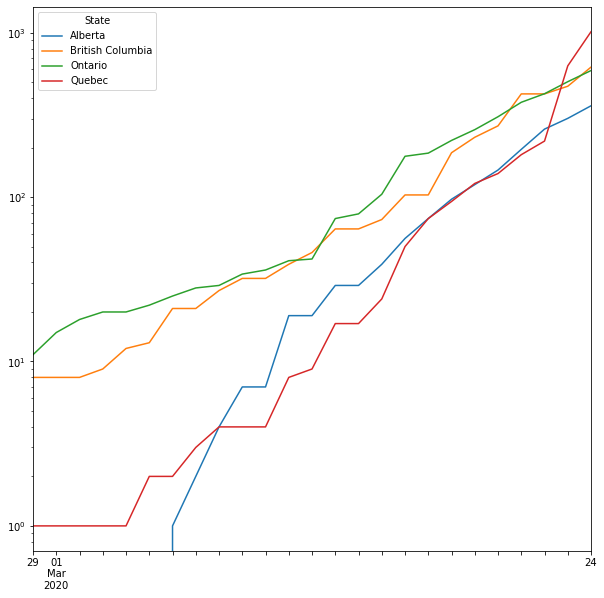

In [9]:
# Load Data
datapath = '../expdev07/all.json'

statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t', names=['code','state'])
statecodes = dict(zip(statecodes['code'],statecodes['state']))
#print(statecodes)
df = []
covered = set()
with open(datapath, 'r', encoding='utf-8') as inFh:
    data = json.load(inFh)
    print(data.keys())
    for row in data['confirmed']['locations']:
        country = row['country']
        province = row['province']
        county = ''
        #print(province)
        if ',' in province:
            #print(province)
            (county,state) = province.split(',')
            if state.strip() == 'D.C.':
                pass
            else:
                county=county.strip()
                province = statecodes[state.strip()]
        for h in row['history']:            
            df.append({'country':country, 'State': province,'county':county, 'Date': h, 'value':row['history'][h]})
    df=pd.DataFrame(df)

df = df[df['country'].isin(['Canada'])]
df.index = pd.to_datetime(df['Date'])
maxDate=max(df.index)
del df['Date']
del df['country']
#df.sum()
df=df.groupby(['State','Date']).sum()
df= df.unstack('Date', fill_value=0)
dates = [c for c in df.columns if df[c].max()>10]
#print(dates)

df = df[dates].transpose()
   
selected = [c for c in df.columns if df[c].iloc[-1]>100 or c in ['Ontario','Quebec','British Columbia']]

#print(selected)
filtered = df[selected]
df=filtered
df.index = [c[1] for c in df.index]
#print(df.index)
df
ax=df.plot(logy=True, xticks=df.index)
#ax.set_xticks(df.index)
savedir = os.path.join('data',maxDate.strftime('%Y%m%d'))
if not os.path.isdir(savedir):
    os.makedirs(savedir)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]

In [11]:
threshold = 100
for c in df.columns:    
    for i,a in enumerate(df[c]):            
        if a>=threshold:
            df[c]=df[c].shift(-i)            
            break
df=df.reset_index(drop=True)
df

State,Alberta,British Columbia,Ontario,Quebec
0,119.0,103.0,104.0,121.0
1,146.0,103.0,177.0,139.0
2,195.0,186.0,185.0,181.0
3,259.0,231.0,221.0,219.0
4,301.0,271.0,257.0,628.0
5,359.0,424.0,308.0,1013.0
6,NaN,424.0,377.0,NaN
7,NaN,472.0,425.0,NaN
8,NaN,617.0,503.0,NaN
9,NaN,NaN,588.0,NaN


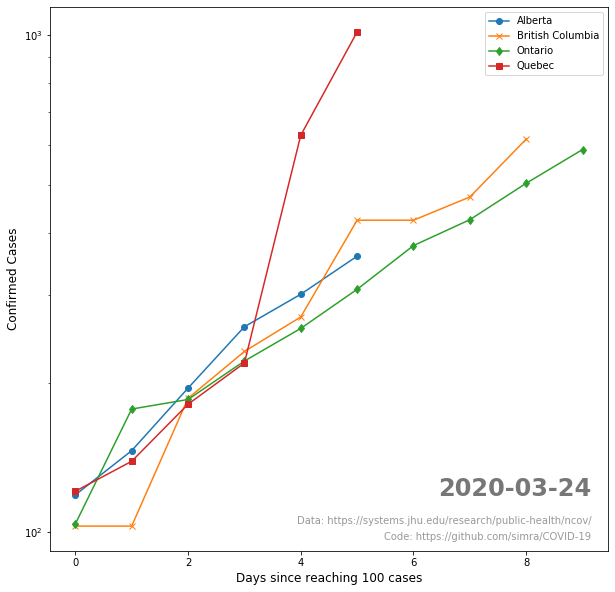

In [12]:
from math import ceil
import matplotlib.font_manager as font_manager
fig, ax = plt.subplots()
markers = [item for sublist in ['oxds*v']*ceil(len(df.columns)/5) for item in sublist]
#df.plot(logy=True, ax=ax) #, ax=ax)
for c,m in zip(df,markers):
    df[c].plot(logy=True, marker=m,  ax=ax)

ax.set_ylabel('Confirmed Cases', size=12)
ax.set_xlabel('Days since reaching {} cases'.format(threshold), size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=10)
ax.legend(prop=font)
plt.savefig(os.path.join(savedir,'4_states_provinces.png'))